In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point,MultiPoint,Polygon
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

sns.set(font_scale=1.3)
sns.set_style("white")

# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.utils as su
import sklearn.metrics as sm
#from matplotlib import pyplot

In [3]:
import sklearn
print(sklearn.__version__)

0.24.2


In [4]:
data_Wildfire_eachyear_all = pd.read_csv("Wildfire_eachyear_feature.csv")
data_Wildfire_eachyear_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                34 non-null     int64  
 1   Wild_Freq           34 non-null     int64  
 2   Wild_Area(ha)       34 non-null     float64
 3   air_mean(DegC)      34 non-null     float64
 4   pre_mean(mm/month)  34 non-null     float64
 5   soilw_mean(mm)      34 non-null     float64
 6   wind_mean(m/s)      34 non-null     float64
 7   slope_mean          34 non-null     float64
 8   NDVI_mean           34 non-null     float64
 9   vegetation          34 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 2.8 KB


In [11]:
# calculate VIF for each variance
def checkVIF_new(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    #df["Const"] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    VIF = VIF.drop(index=(VIF["feature"].loc[(VIF["feature"] == "c")].index))
    max_VIF = VIF["VIF"].max()
    print(max_VIF)
    return VIF
data_Wildfire_eachfire_X = pd.DataFrame(data_Wildfire_eachyear_all,columns=["air_mean(DegC)","pre_mean(mm/month)","soilw_mean(mm)","wind_mean(m/s)",\
                                                                           "slope_mean","NDVI_mean","vegetation"])
data_Wildfire_eachfire_y = pd.DataFrame(data_Wildfire_eachyear_all,columns=["Wild_Freq"])
X_rep = data_Wildfire_eachfire_X.copy()
X_rep["c"] = 1 # 常数项
X_rep.head()
VIF = checkVIF_new(X_rep)
VIF_2 = VIF.copy()
# save VIF data
VIF_2.loc[3:3,("feature")]=["wind_mean (m/s)"]
VIF_2.loc[5:5,("feature")]=["NDVI_mean"]
VIF_2.loc[6:6,("feature")]=["Vegetation"]
VIF_2.to_csv("./VIF_Wildfire_Frequency.csv",header=True,index=False)
VIF_2

6.11818932800178


,feature,VIF
0,air_mean(DegC),1.618190
1,pre_mean(mm/month),5.865225
2,soilw_mean(mm),6.118189
3,wind_mean (m/s),1.340850
4,slope_mean,2.546120
5,NDVI_mean,2.247389
6,Vegetation,1.147976


Text(0.5,1,'Variance inflation factor (VIF)')

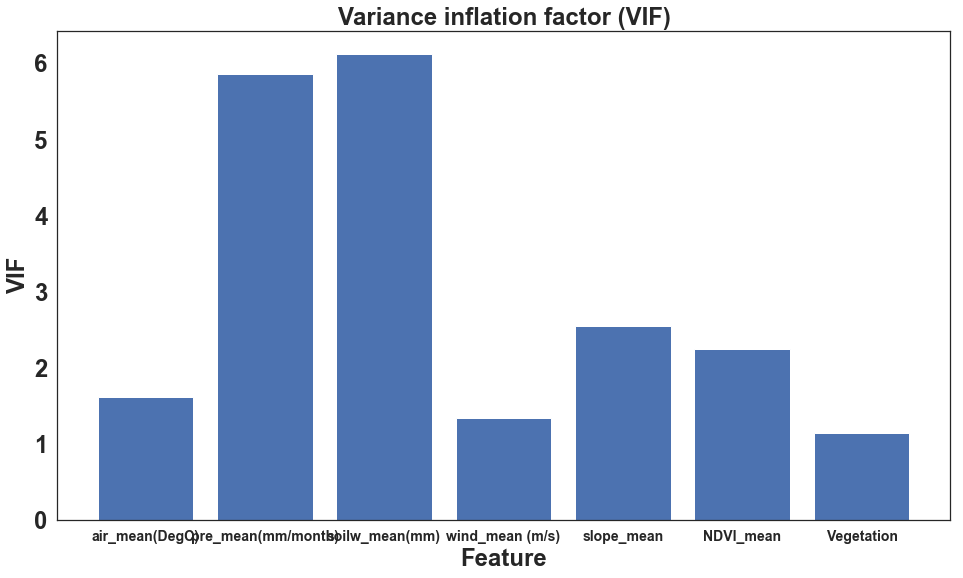

In [6]:
# 绘制VIF条形图
plt.figure(figsize=(16,9))
plt.bar(VIF_2["feature"],VIF_2["VIF"])
plt.xlabel("Feature",fontsize=24,fontweight="bold")
plt.ylabel("VIF",fontsize=24,fontweight="bold")
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')
plt.title("Variance inflation factor (VIF)",fontsize=24,fontweight="bold")
#plt.savefig("VIF_wildfire_frequency.tiff")

In [7]:
# define the model
model = RandomForestRegressor(max_depth=10,n_estimators=400,random_state=1,min_samples_split=5,max_leaf_nodes=60,min_weight_fraction_leaf=0.02,bootstrap=True,oob_score=True)
# fit the model
model.fit(data_Wildfire_eachfire_X, data_Wildfire_eachfire_y)
# regression score
score = model.score(data_Wildfire_eachfire_X, data_Wildfire_eachfire_y)
print("RandomForest---score: %.5f" % (score))
oob_score = model.oob_score_
print("RandomForest---oob_score: %.5f" % (oob_score))
# get importance
importance = model.feature_importances_
# get columns name
list_name = list(data_Wildfire_eachfire_X)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, \t Score: %.5f' % (list_name[i],v))

D:\ProgramFile\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForest---score: 0.80514
RandomForest---oob_score: 0.05966
Feature: air_mean(DegC), 	 Score: 0.09189
Feature: pre_mean(mm/month), 	 Score: 0.17557
Feature: soilw_mean(mm), 	 Score: 0.08632
Feature: wind_mean(m/s), 	 Score: 0.37152
Feature: slope_mean, 	 Score: 0.06308
Feature: NDVI_mean, 	 Score: 0.06202
Feature: vegetation, 	 Score: 0.14959


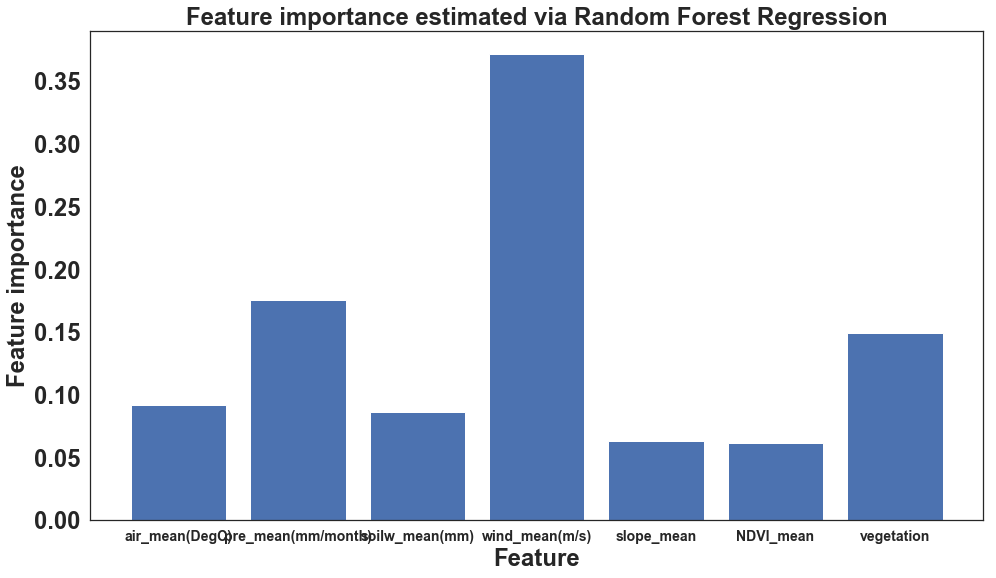

In [10]:
# 绘制importance条形图
plt.figure(figsize=(16,9))
plt.bar(list_name,importance)
plt.xlabel("Feature",fontsize=24,fontweight="bold")
plt.ylabel("Feature importance",fontsize=24,fontweight="bold")
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')
plt.title("Feature importance estimated via Random Forest Regression",fontsize=24,fontweight="bold")
#plt.savefig("FeatureImportance_wildfire_frequency.tiff")
plt.show()

In [12]:
# save data
df_FeatureImportance = pd.DataFrame({"Feature":np.array(list_name), 
                                       "Feature importance":np.array(importance)})
df_FeatureImportance.to_csv("./FeatureImportance_Wildfire_frequency.csv",header=True,index=False)
df_FeatureImportance

,Feature,Feature importance
0,air_mean(DegC),0.091889
1,pre_mean(mm/month),0.175574
2,soilw_mean(mm),0.086323
3,wind_mean(m/s),0.371522
4,slope_mean,0.063082
5,NDVI_mean,0.062018
6,vegetation,0.149592
